# CoSpar basics

Below, we walk you through typical steps of analysis. We use the subsampled hematopoiesis dataset so that this tutorial can be run within a few minutes.
For further demonstration, please see notebooks in the **Examples** section. 

**Contents**:
    
* Initialization

* Preprocessing and dimension reduction (optional)

* Raw clonal data analysis (without using state information)

* Transition map inference

* Save or load pre-computed data (optional)

* Plotting

* Miscellaneous

In [1]:
import cospar as cs

In [2]:
cs.logging.print_version()

# Set the messaging level. At a given value, a running function will 
# print information at or below its level.  
cs.settings.verbosity=3 #range: 0 (error),1 (warning),2 (info),3 (hint). 

# Plot setting. If you want to control a particular plot, 
# just change the setting here, and run that plotting function.
cs.settings.set_figure_params(format='png',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=2) 

Running cospar 0.0.8 (python 3.6.12) on 2021-02-17 19:09.


Each dataset should have its own folder to avoid conflicts.  

In [3]:
# set the directory for figures and data. If not existed yet, they will be created automtaically.
cs.settings.data_path='data_cospar' 
cs.settings.figure_path='fig_cospar' 

## Initialization

The first step is to construct an ``anndata`` object that stores all relevant data. The input data are:

* **RNA_count_matrix**: shape (n_cell, n_gene), mandatory, stored at `adata.X` 

* **gene_names**: list of gene names, shape (n_genes,), mandatory, stored at `adata.var_names`

* **time_info**: list of time annotation in string, shape (n_cell,), mandatory, stored at `adata.obs['time_info']`

* **X_clone**: clonal label for each cell in the form of np.array or sparse matrix, shape (n_cell, n_clone), optional, stored at `adata.obsm['X_clone']`  
    
* **X_pca**: PCA matrixs, shape (n_cell, n_pcs), optional, stored at `adata.obsm['X_pca']`  

* **X_emb**: two-dimensional embedding, shape (n_cell, 2), optional, stored at `adata.obsm['X_emb']`  

* **state_info**: state annotation for each cell, shape (n_cell, 1), optional, stored at `adata.obsm['state_info']` 

The clonal data `X_clone` is optional. If not provided, cospar generates the transition map based on state information only.
A clone means a barcode that labels cells. We allow a cell to have multiple barcodes (possibly at different time points), thus belonging to multiple clones.   

`X_pca`, `X_emb`, and `state_info` are also optional. They can be generated in downstream preprocessing and dimension reduction steps. 

We provide a function to help to initialize this object. We mimic this step by loading a preprocessed dataset, extracting each component, 
and then re-assembling them using our initialization function. 

Load an existing dataset. If you have pre-processed data, you can load it with `cs.hf.read(file_name)`.

In [4]:
adata_orig_0=cs.datasets.hematopoiesis_subsampled()

creating directory data_cospar/ for saving data
creating directory fig_cospar/ for saving figures
try downloading from url
https://kleintools.hms.harvard.edu/tools/downloads/cospar/LARRY_sp500_ranking1_adata_preprocessed.h5ad
... this may take a while but only happens once


Extract each component.

In [5]:
# This is just a name to indicate this data. 
# Will be used to save results. Can be arbitrary but should be unique to this data.
data_des='blood' 

RNA_count_matrix=adata_orig_0.X # np.array or sparse matrix, shape (n_cell, n_gene)
gene_names=adata_orig_0.var_names # List of gene names, shape (n_genes,)     
    
# Clonal data matrix, np.array or sparse matrix, shape: (n_cell, n_clone)
X_clone=adata_orig_0.obsm['X_clone'] 

# 2-d embedding, np.array, shape: (n_cell, 2)
X_emb=adata_orig_0.obsm['X_emb'] 

# A vector of cluster id for each cell, np.array, shape: (n_cell, 2),
state_info=adata_orig_0.obs['state_info'] 

# principle component matrix, np.array, shape: (n_cell, n_pcs)
X_pca=adata_orig_0.obsm['X_pca'] 

# A vector of time info, np.array of string, shape: (n_cell,)
time_info=adata_orig_0.obs['time_info']

Now, initialize the adata object.

In [6]:
adata_orig=cs.pp.initialize_adata_object(RNA_count_matrix,gene_names,time_info,
     X_clone=X_clone,X_pca=X_pca,X_emb=X_emb,state_info=state_info,data_des=data_des)

All time points: {'2', '6', '4'}
Time points with clonal info: {'2', '6', '4'}


The ordering of time points are important for downstream application. They should be in ascending order. While we use simple sorting to order the time points, this may not be accurate as each time point is a string. If the result is not good, you can update it here (optional):

In [7]:
cs.hf.update_time_ordering(adata_orig,updated_ordering=['2','4','6'])

This is the structure of the initialized adata object:

In [8]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info'
    uns: 'data_des', 'clonal_time_points', 'time_ordering'
    obsm: 'X_clone', 'X_pca', 'X_emb'

Sometimes, you may have many useful annotations attached to your own preprocessed adata object, and you may not want to run `cs.pp.initialize_adata_object`, which erases these annotations. In this case, **you can just attach the above information (`time_info` etc.) into the corresponding field of your own adata object.**

## Preprocessing and dimension reduction (optional)

If the data do not yet have one of `X_pca`, `X_emb`, or `state_info`, you will need to run the preprocessing and dimension reduction. 

Select highly variable genes. Before this, there is count normalization. 

Finding highly variable genes...


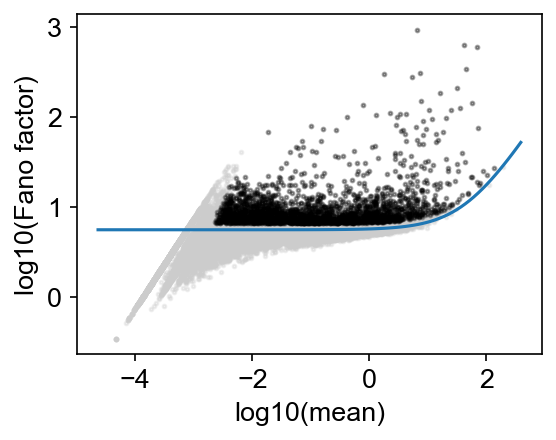

Keeping 2489 genes


In [9]:
cs.pp.get_highly_variable_genes(adata_orig,normalized_counts_per_cell=10000,min_counts=3, 
        min_cells=3, min_gene_vscore_pctl=85)

Compute for each gene its correlation with a set of cell cycle genes. There is a default cell cycle gene set for mouse.
You might need to use your own genes. This step is optional, but recommended. 

adata.var['highly_variable'] not updated.
Please choose corr_threshold properly, and set confirm_change=True


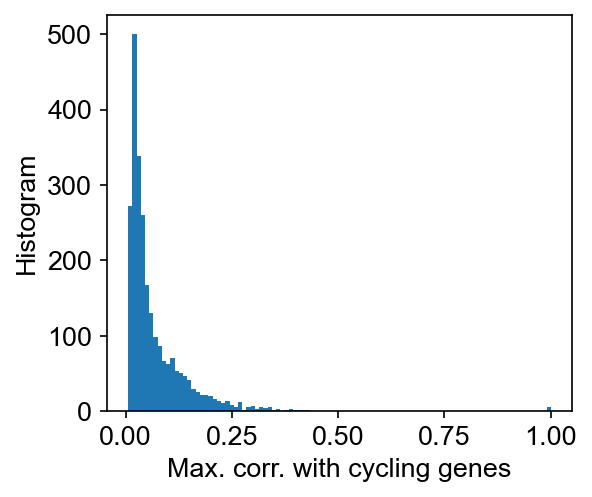

In [10]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig)

Now, actually confirm the change at a specific cutoff threshold. 

In [11]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.1,confirm_change=True)

Number of selected non-cycling highly variable genes: 1958
Remove 531 cell cycle correlated genes.
adata.var['highly_variable'] updated


Compute the `X_pca`, `X_emb`, and `state_info` (from clustering). `X_pca` will be used to build the similarity matrix later. `X_emb` is only used for visualization. You can also pass your favoriate embedding directly to 
`adata.obsm['X_emb']`.

In [12]:
update=False
if update:
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40) 
    #cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3) #Do not run this, as we want to keep the original embedding
    #cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) # Do not run this, as we want to keep the original state annotation.

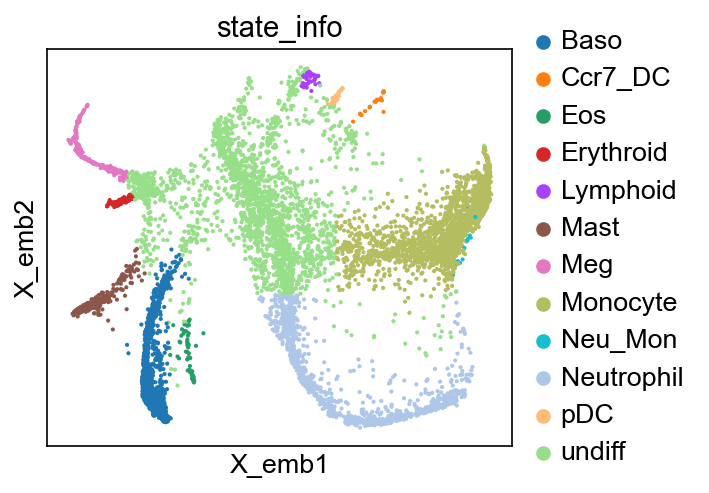

In [13]:
cs.pl.embedding(adata_orig,color='state_info')

In [14]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['Ccr7_DC', 'Baso', 'Meg', 'undiff', 'Neutrophil', 'Erythroid', 'Mast', 'Monocyte', 'Neu_Mon', 'Lymphoid', 'Eos', 'pDC']
Available time points: ['2', '6', '4']
Clonal time points: ['2', '6', '4']


You can choose to save preprocessed data. It can be loaded using `cs.hf.read(file_name)`. 

In [15]:
save=False
if save:
    cs.hf.save_preprocessed_adata(adata_orig)

### Raw clonal data analysis

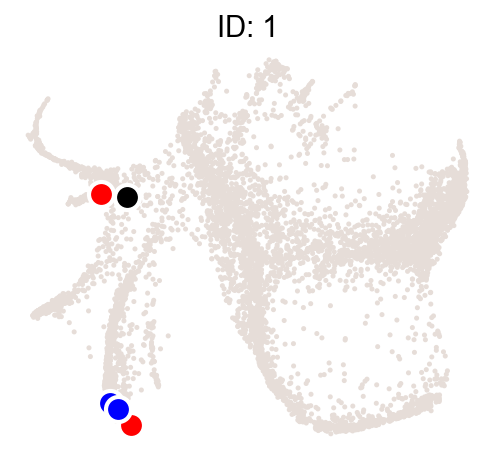

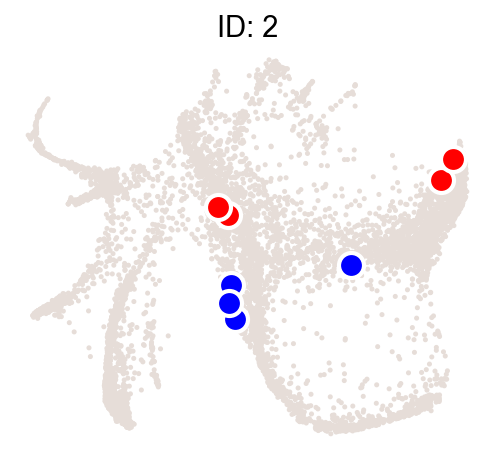

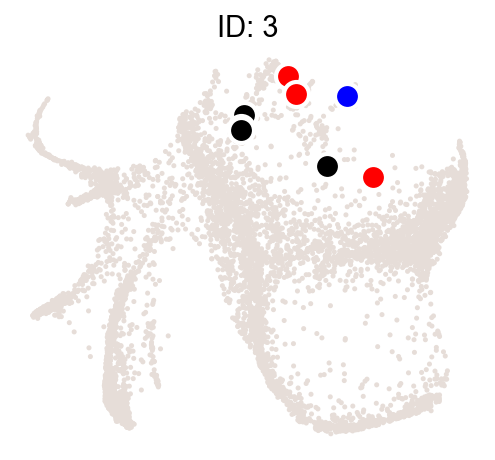

In [16]:
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[1,2,3],color_list=['black','red','blue'])

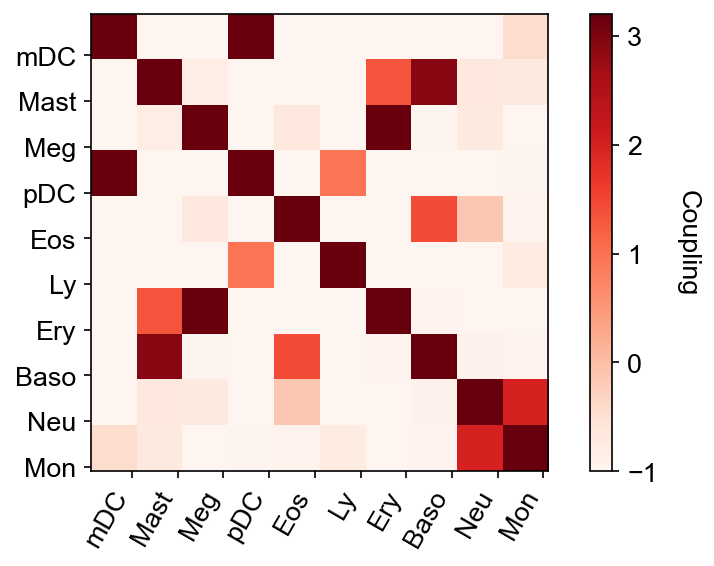

In [17]:
selected_time_point='4'
selected_fates=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
cs.pl.fate_coupling_from_clones(adata_orig,selected_time_point, selected_fates=selected_fates, 
                                color_bar=True,rename_selected_fates=celltype_names)

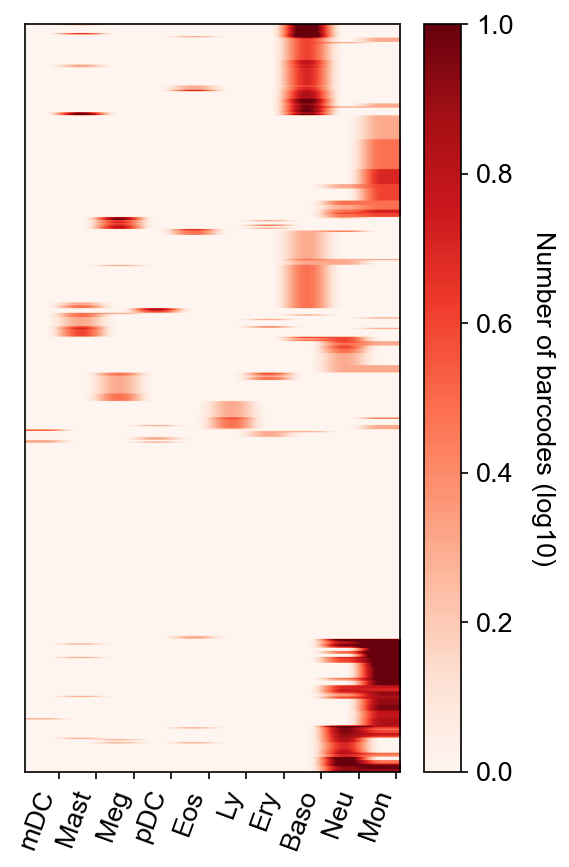

In [18]:
selected_time_point='4'
cs.pl.barcode_heatmap(adata_orig,selected_time_point, selected_fates=selected_fates, 
                                color_bar=True,rename_selected_fates=celltype_names)

This step is slow and optional. The time is linearly proportional to the multiplication of clone number and N_resampling. It takes half a minute for the given parameters. To gain stronger statistical power, increase `N_resampling`.

Current clone id: 0
Current clone id: 50
Current clone id: 100
Current clone id: 150
Current clone id: 200
Current clone id: 250
Current clone id: 300
Current clone id: 350
Current clone id: 400
Current clone id: 450


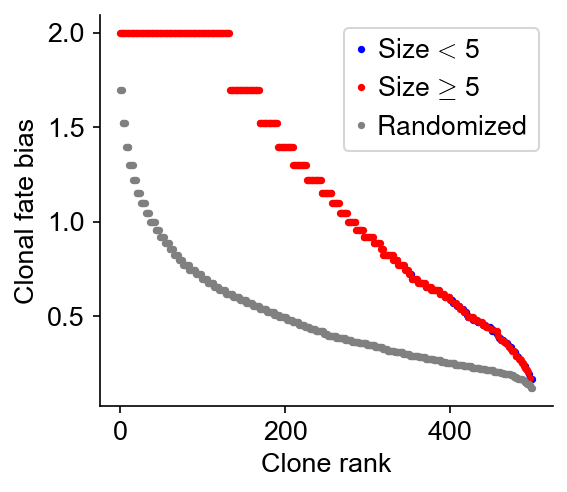

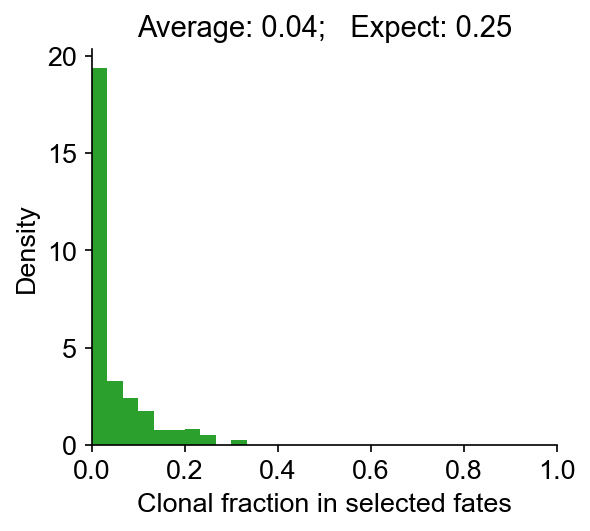

In [19]:
clonal_fate_bias,clone_id=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Monocyte',
            clone_size_thresh=5,N_resampling=100,compute_new=False)

## Transition map inference

As mentioned in **Getting Started**, there are several methods for map inference. Below, we illustrate the one that uses multiple clonal time points and integrates state and clonal information. The first time it runs, it will compute the similarity matrix at different smooth rounds and save them. Then, it will infer the transition map. It takes 2-3 mins to run for the first time, and 10-20 s for later runs. Some key parameters:
    
* **smooth_array**: a list of numbers defining the smooth rounds at each iteration of coherent sparsity optimization. Its length determines the number of iteration. We found that 3 iteration rounds are generally sufficient. We recommend using descending smooth rounds to mimic simulated annealing. It is better to use a number at the multiple of 5, i.e., 5, 10, 15, 20,…
    
* **noise_threshold**: noise threshold to remove spurious transitions in the updated transition map, in the range [0,1].

-------Step 1: Select time points---------
--> Clonal cell fraction (day 2-4): 1.0
--> Clonal cell fraction (day 4-6): 1.0
--> Clonal cell fraction (day 4-2): 0.3892466194462331
--> Clonal cell fraction (day 6-4): 1.0
--> Numer of cells that are clonally related -- day 2: 286  and day 4: 1209
--> Numer of cells that are clonally related -- day 4: 3106  and day 6: 4046
Valid clone number 'FOR' post selection 500
Cell number=7438, Clone number=500
-------Step 2: Compute the full Similarity matrix if necessary---------
Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.020160913467407227
Smooth round: 2
--> Time elapsed: 0.1444258689880371
Smooth round: 3
--> Time elapsed: 0.5122900009155273
--> Orignal sparsity=0.11405884956222492, Thresholding
--> Final sparsity=0.07885019703258508
similarity matrix truncated (Smooth round=3):  0.5714099407196045
Smooth round: 4
--> Time elapsed: 1.0013768672943115
--> Orignal sparsity=0.18045154273806427, Thresholdin

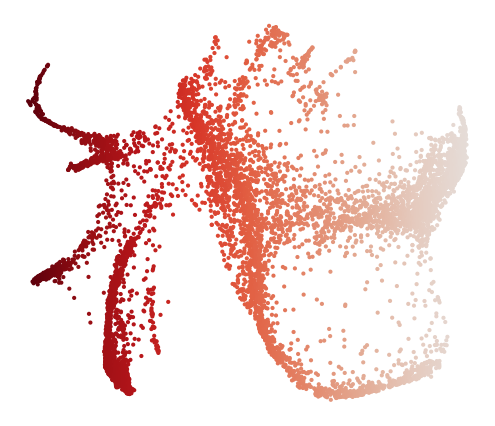

In [20]:
noise_threshold=0.2 # 
selected_clonal_time_points=['2','4','6']
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,selected_clonal_time_points,smooth_array=[20,15,10],
        noise_threshold=noise_threshold,demulti_threshold=noise_threshold,use_full_Smatrix=True)

We can see that after this step, we have two maps: `'transition_map'` and `'intraclone_transition_map'`. Both of them can be used 
    for downstream analysis. 

In [21]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Available clusters: ['Ccr7_DC', 'Baso', 'Meg', 'undiff', 'Neutrophil', 'Erythroid', 'Mast', 'Monocyte', 'Neu_Mon', 'Lymphoid', 'Eos', 'pDC']
Available time points: ['2', '6', '4']
Clonal time points: ['2', '6', '4']


## Save or load pre-computed data (optional)

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata would print the `data_des`, which can be used to load the corresponding adata.

In [22]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    # updated Jan 27, 2021
    #data_des='blood_TwoTimeClone_t*4*6'
    #data_des='blood_MultiTimeClone_0_t*2*4*6'
    data_des='blood_OneTimeClone_t*4*6'
    adata=cs.hf.load_saved_adata_with_key(data_des)

## Plotting

There are some common parameters:

* `used_map_name` (str). It determines which transition map to use for analysis. Choices: {‘transition_map’, ‘intraclone_transition_map’, ‘OT_transition_map’, ‘HighVar_transition_map’,’clonal_transition_map’}

* `selected_fates` (list of str). Selected clusters to aggregate differentiation dynamics and visualize fate bias etc.. It allows nested structure, e.g., selected_fates=[‘a’, [‘b’, ‘c’]] selects two clusters: cluster ‘a’ and the other that combines ‘b’ and ‘c’.

* `map_backwards` (bool, default True). We can analyze either the forward transitions, i.e., where the selected states or clusters are going (map_backwards=False), or the backward transitions, i.e., where these selected states or clusters came from (map_backwards=True). The latter is more useful, and is the default.

* `selected_time_points` (list, default all). List of time points to use. By default, all are used. 

* `normalize_by_fate_size` (bool, default False). Normalize the fate probability Prob(X) towards a cluster X by the expected probability, i.e., the fraction of cells within the targeted cluster X at the corresponding time point.  

### Plotting transition profiles for single cells

First, check the forward transitions (i.e., future states) from the `'transition_map'`.

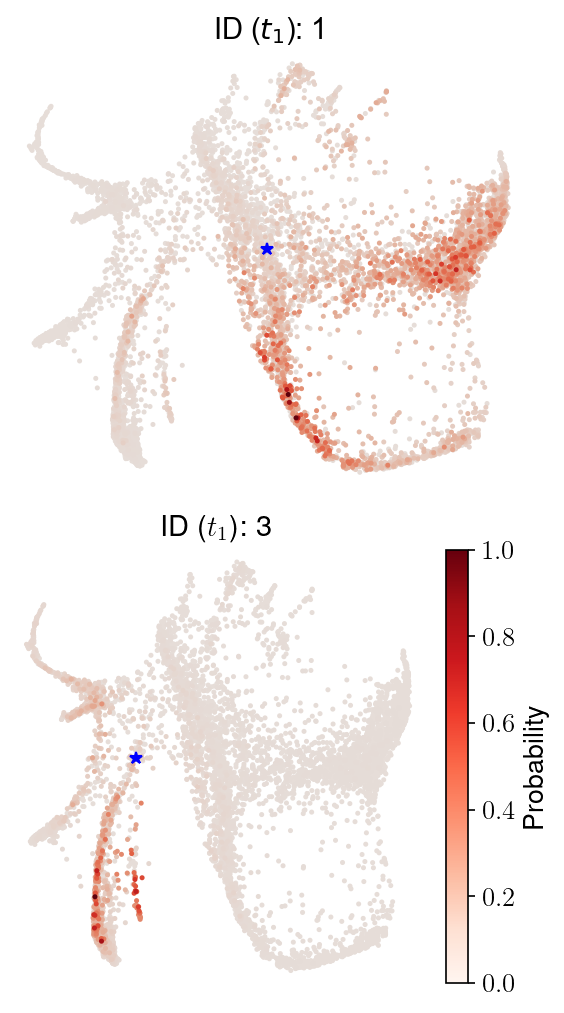

In [23]:
selected_state_id_list=[1,3] # This is a relative ID. Its mapping to the actual cell id depends on map_backwards.

map_backwards=False
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=map_backwards)

Now, backward transitions (i.e., past states) from the same map.

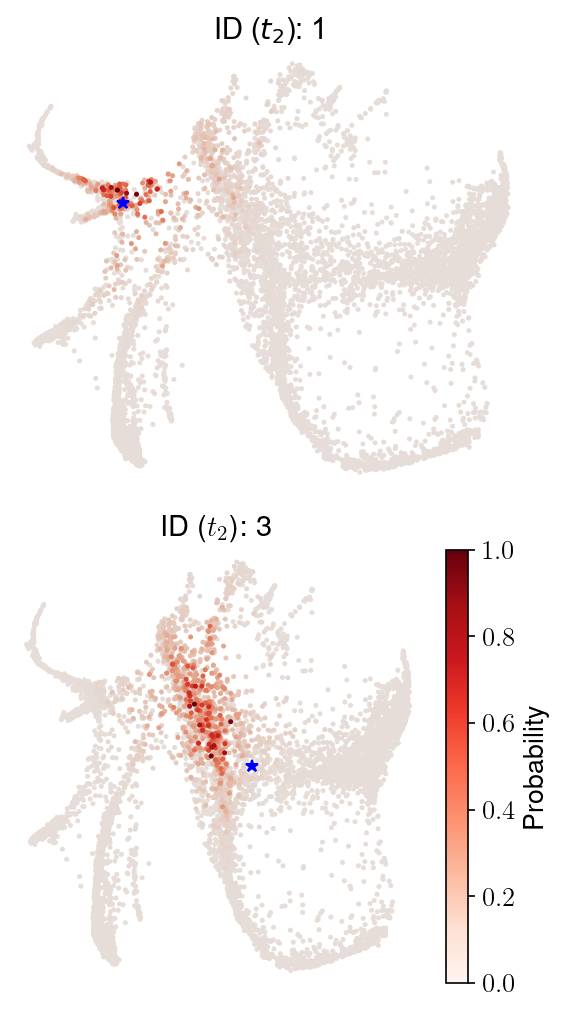

In [24]:
selected_state_id_list=[1,3]
map_backwards=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=map_backwards)

Finally, switch to the `'intraclone_transition_map'`, and check backward transitions. We can see that the second id does not have corresponding clonally related initial states.

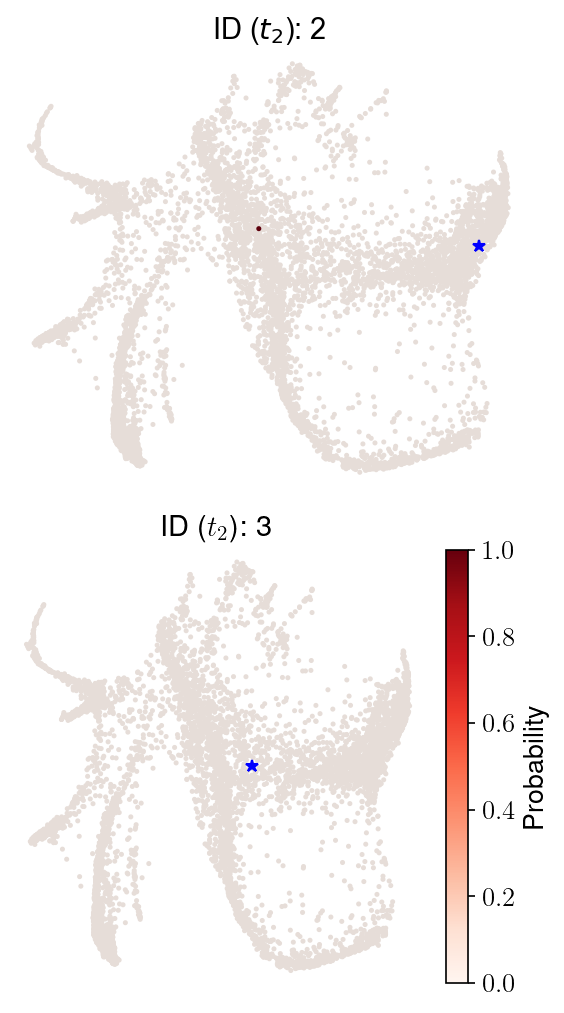

In [25]:
selected_state_id_list=[2,3] 
map_backwards=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='intraclone_transition_map',map_backwards=map_backwards)

### Fate map

Inspect the backward transitions, and ask where the selected fate clusters are at the previous time point.

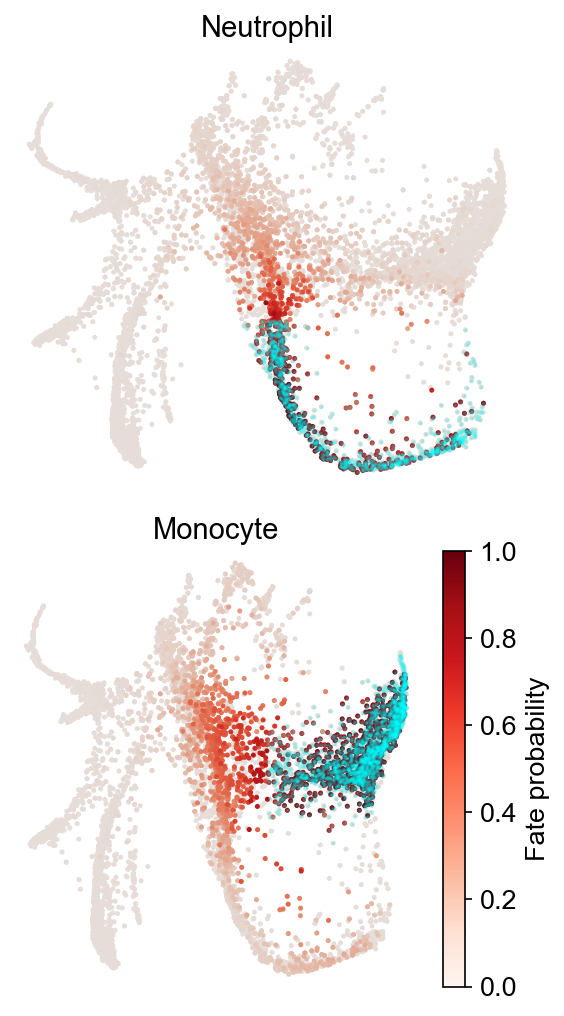

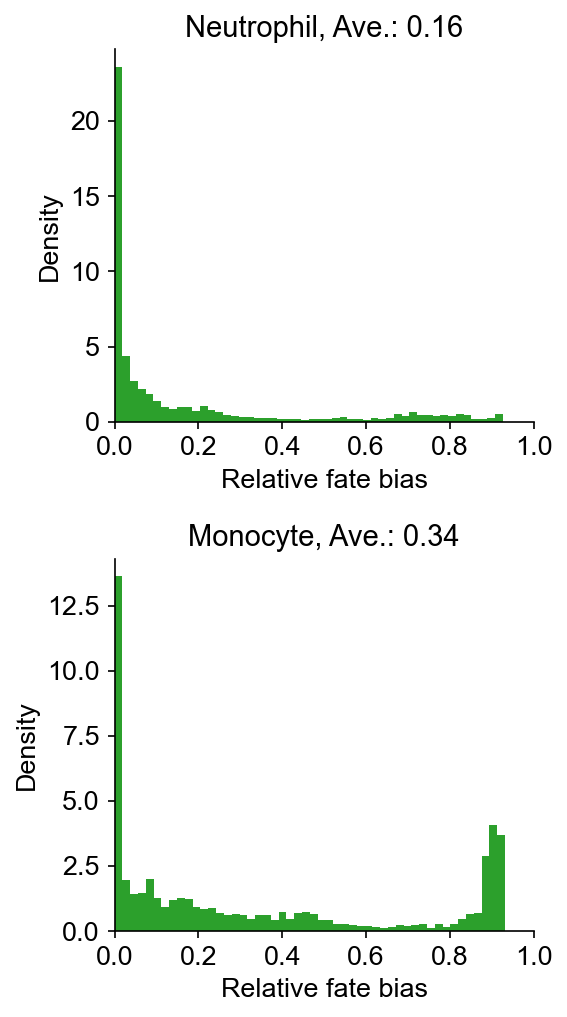

In [26]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_map_name='transition_map',map_backwards=True,plot_target_state=True,show_histogram=True)

Now, do the same thing with `'intraclone_transition_map'`.

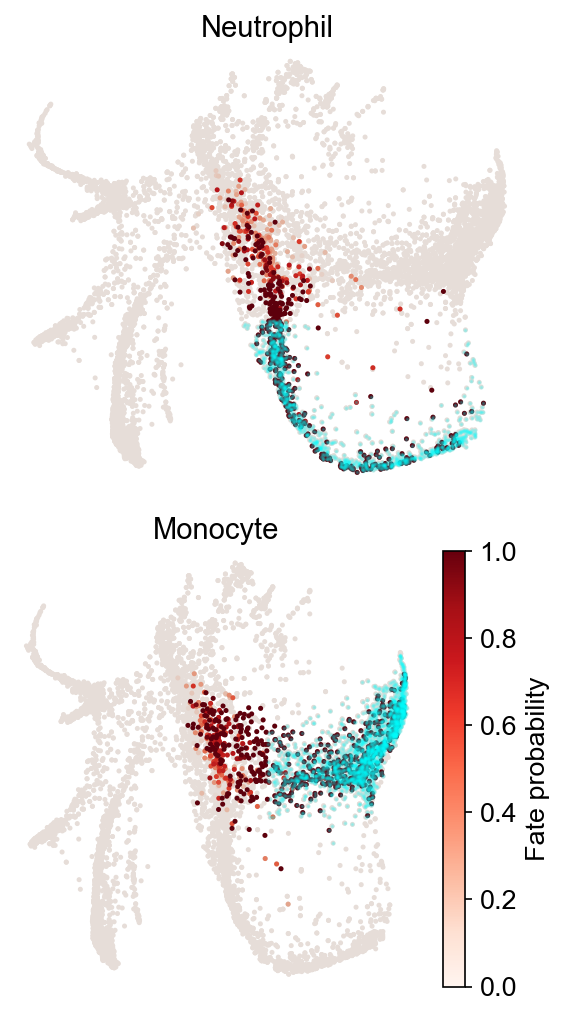

In [27]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_map_name='intraclone_transition_map',map_backwards=True,
               plot_target_state=True,show_histogram=False)

As a comparison, if we use only the clonal information to construct the transition map, this is what it looks like:

Current time ordering from simple sorting: ['2' '4' '6']
--> Clonal cell fraction (day 2-4): 1.0
--> Clonal cell fraction (day 4-6): 1.0
--> Clonal cell fraction (day 4-2): 0.3892466194462331
--> Clonal cell fraction (day 6-4): 1.0
--> Numer of cells that are clonally related -- day 2: 286  and day 4: 1209
--> Numer of cells that are clonally related -- day 4: 3106  and day 6: 4046
Valid clone number 'FOR' post selection 500
Cell number=7438, Clone number=500
Use only uni-potent clones (weinreb method)
Used uni-potent clone fraction 0.146
Use only uni-potent clones (weinreb method)
Used uni-potent clone fraction 0.598


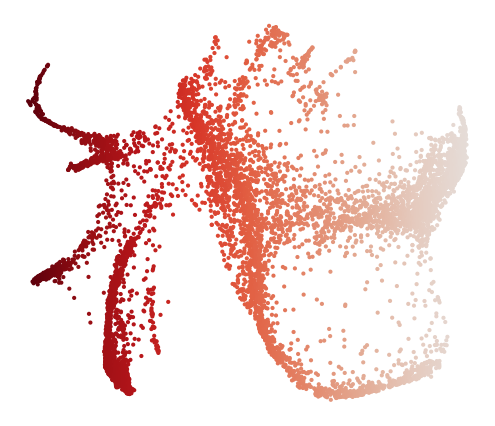

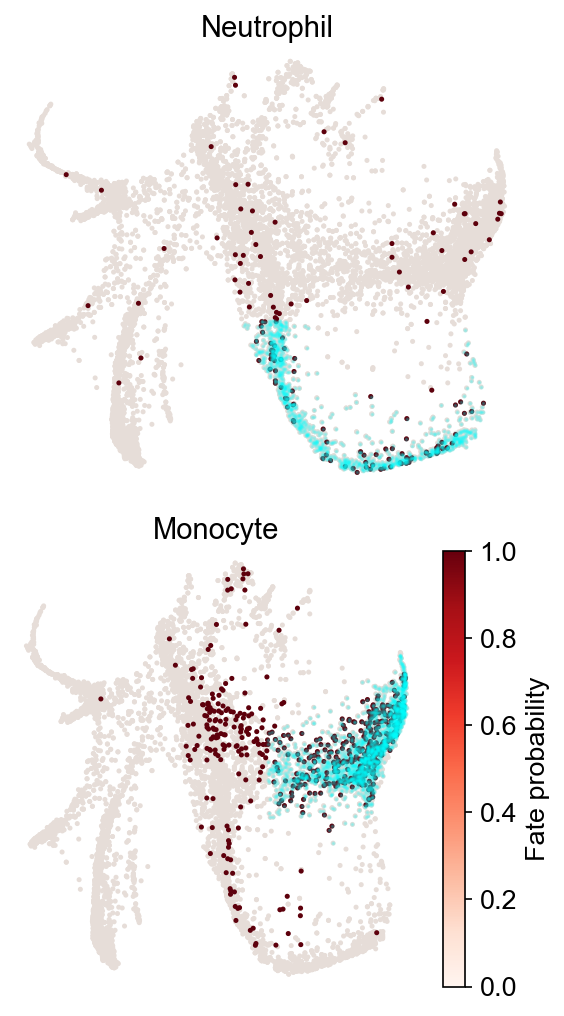

In [28]:
cs.tmap.infer_Tmap_from_clonal_info_alone(adata,method='weinreb')

cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_map_name='clonal_transition_map',map_backwards=True,
            plot_target_state=True,show_histogram=False)

### Relative fate bias

The fate bias of initial states are defined by competition between two fate clusters A and B, i.e., how strongly A is favored than B. Only states with fate probabilities satisfying this criterion will be shown: 

* P(A)+P(B)>sum_fate_prob_thresh

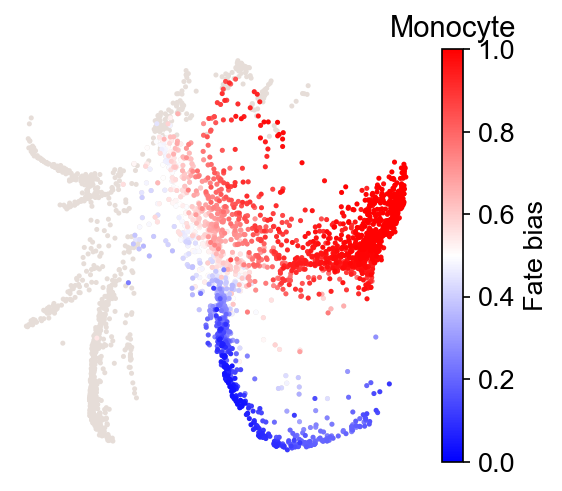

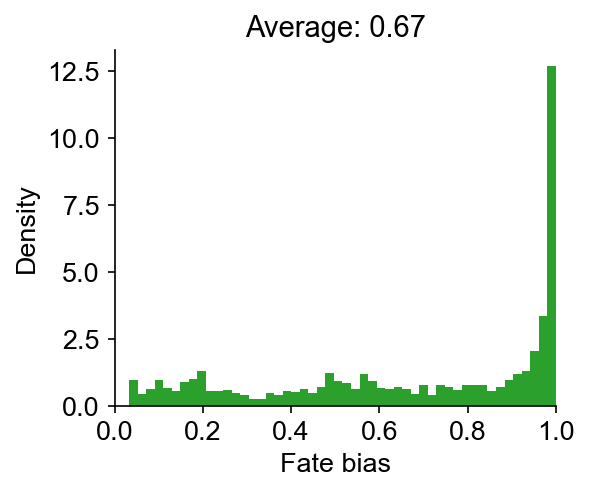

In [29]:
cs.pl.binary_fate_bias(adata,selected_fates=['Monocyte','Neutrophil'],used_map_name='transition_map',
            selected_time_points=['4'],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

If we normalize the fate probability by the cluster size with `normalize_by_fate_size=True`:

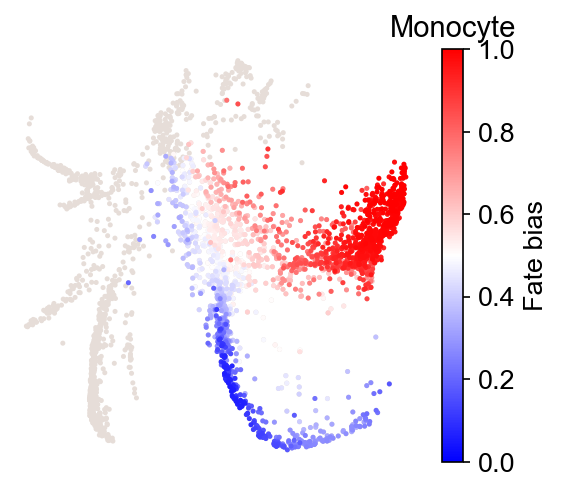

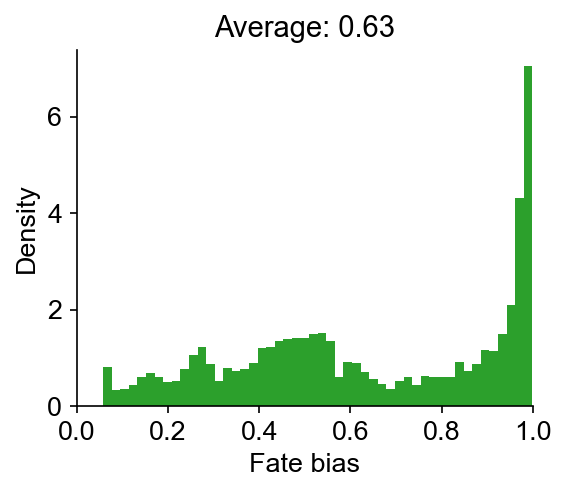

In [30]:
cs.pl.binary_fate_bias(adata,selected_fates=['Monocyte','Neutrophil'],used_map_name='transition_map',
        normalize_by_fate_size=True,selected_time_points=['4'],plot_target_state=False,
                       map_backwards=True,sum_fate_prob_thresh=0.5)

Now, try the `intraclone_transition_map`.

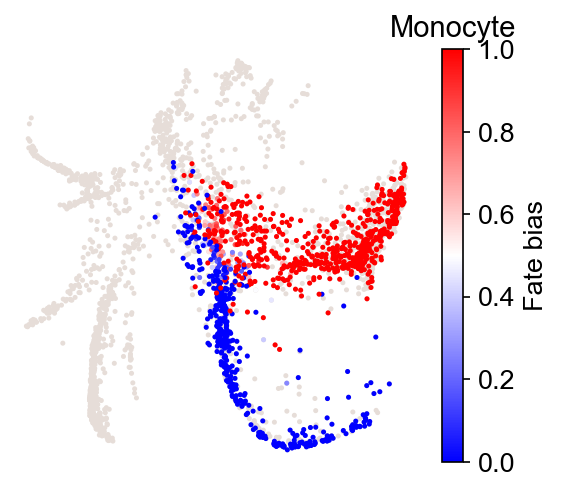

In [31]:
cs.pl.binary_fate_bias(adata,selected_fates=['Monocyte','Neutrophil'],used_map_name='intraclone_transition_map',
            selected_time_points=['4'],plot_target_state=False,map_backwards=True,
                       sum_fate_prob_thresh=0.1,show_histogram=False)

### Dynamic trajectory inference

One way to define the dynamic trajectory is simply mapping a given fate cluster backward in time. The whole trajectory across
multiple time points will be saved at `adata.uns['dynamic_trajectory']`. This method performs best if there are multiple clonal time points. 

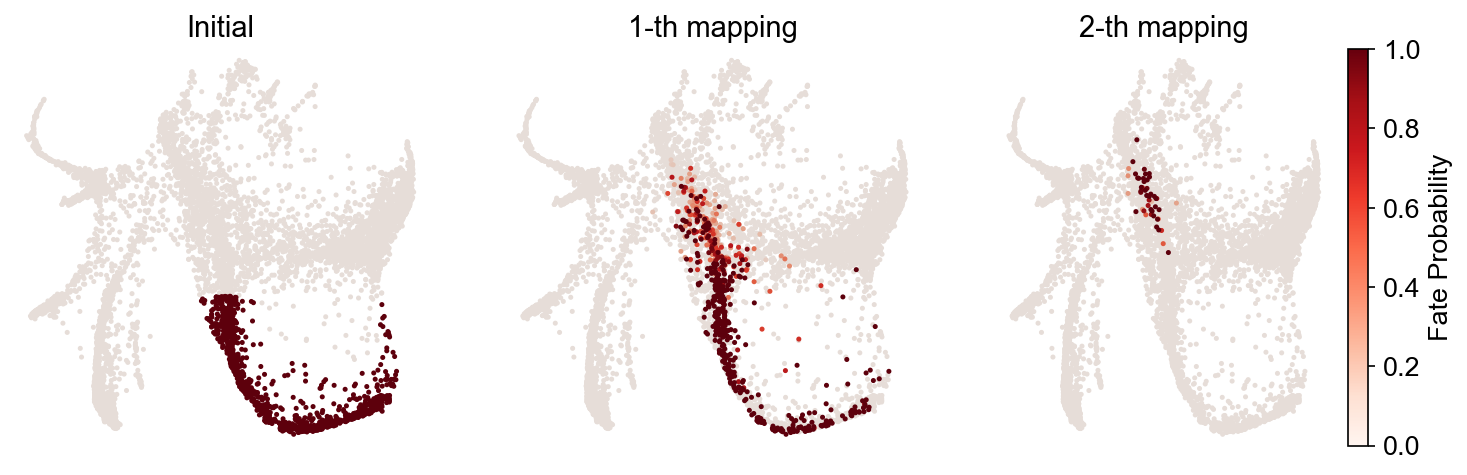

In [32]:
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Neutrophil',plot_separately=True,used_map_name='intraclone_transition_map')

We can also infer the dynamic trajectory and ancestor population using the fate bias from binary fate competition. Here, fate bias is a scalar between (0,1) at each state. Selected ancestor population satisfies:

   * Prob(A)+Prob(B)>sum_fate_prob_thresh; 

   * Ancestor states for A: Bias>0.5+bias_threshold

   * Ancestor states for B: bias<0.5+bias_threshold

They will be stored at `adata.uns['cell_group_A']` and `adata.uns['cell_group_B']`. The selected states along with the corresponding fate cluster will be stored at `adata.uns['dynamic_trajectory']` for inspecting dynamic gene expression. 

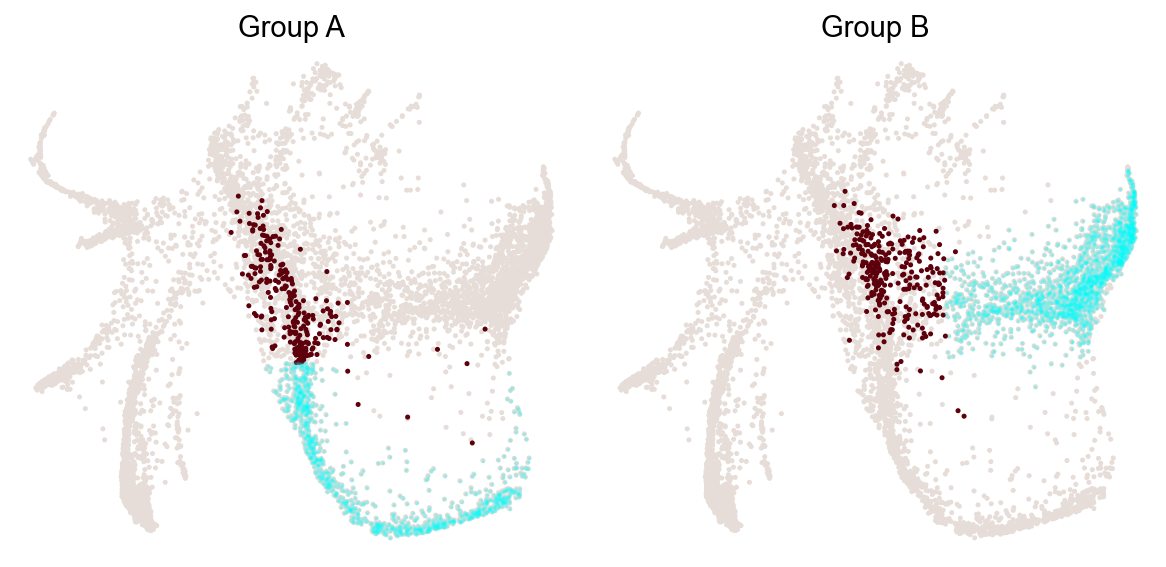

In [33]:
cs.pl.dynamic_trajectory_from_binary_fate_bias(adata, selected_fates=['Neutrophil','Monocyte'], 
 used_map_name='intraclone_transition_map', map_backwards=True, 
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=True)

### Differential genes for two ancestor groups

It would be interesting to see what genes are differentially expressed between these two ancestor populations, which might drive the fate bifurcation. The two population can be accessed at `adata.obs['cell_group_A']` and `adata.obs['cell_group_B']`. We provide a simple differentiation gene expression analysis that uses Wilcoxon rank-sum test to calculate P values, followed by Benjamini-Hochberg correction. You can always use your method.

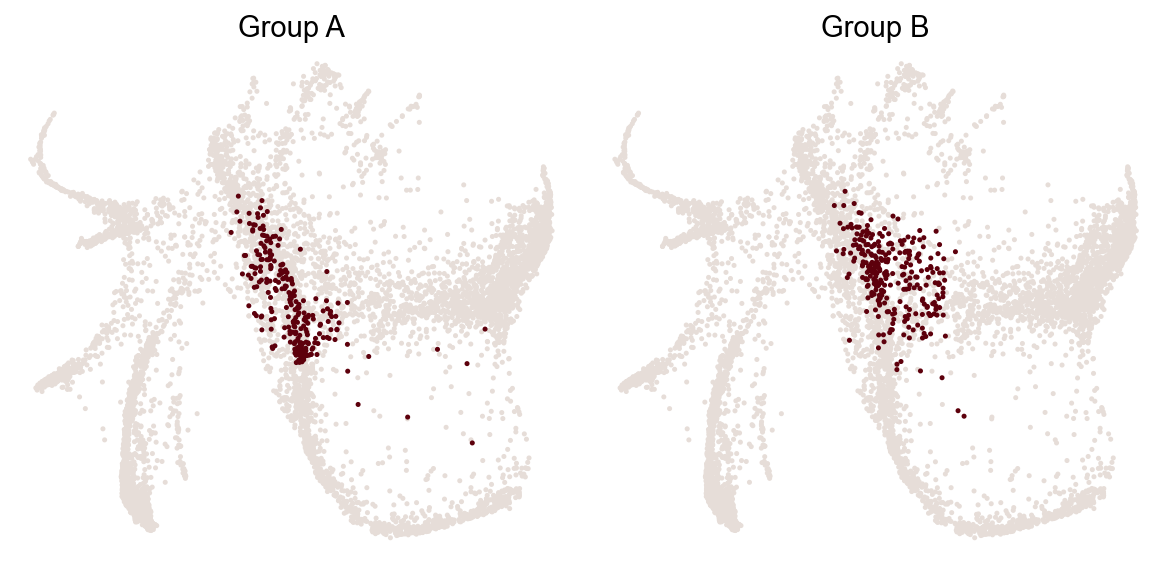

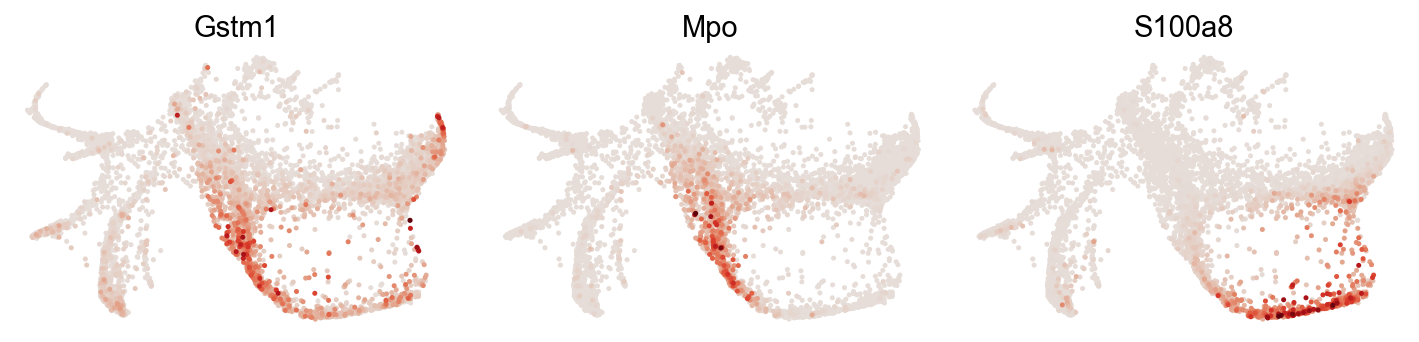

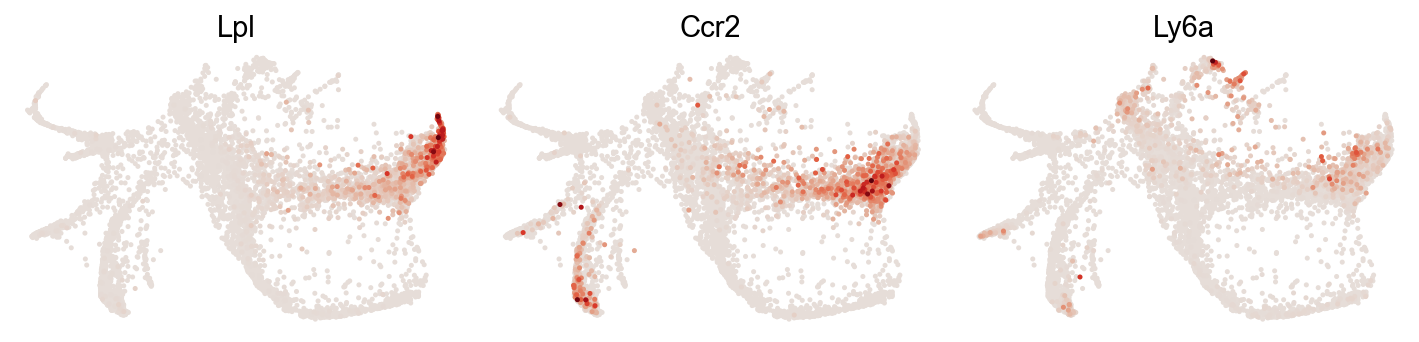

In [34]:
# This step requires that adata.obs['cell_group_A'] and adata.obs['cell_group_B'] exist.
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=3)

In [35]:
dge_gene_A

gene            pv     mean_1     mean_2     ratio
1      Gstm1  4.097172e-12   5.639521  12.294149 -1.001640
4        Mpo  8.692889e-09   5.425293  10.983321 -0.899194
108   S100a8  1.167498e-01   5.562388  10.499614 -0.809293
2      Elane  3.883380e-11  11.473849  20.096100 -0.758070
6       Ctsg  1.235147e-07   8.509356  15.002956 -0.750919
...      ...           ...        ...        ...       ...
92      Ppic  1.141734e-01   1.099540   1.618626 -0.318737
133     Wbp5  2.089908e-01   1.818557   2.514561 -0.318388
5169   Anxa1  9.999074e-01   0.950352   1.430243 -0.317366
309    Stag1  6.765967e-01   0.790524   1.230272 -0.316838
3776   Tma16  9.999074e-01   0.231278   0.532453 -0.315685

[100 rows x 5 columns]

If you want to define cell groups by yourself, you can pass the selected cell groups as boolean array into  `adata.obs['cell_group_A']` and `adata.obs['cell_group_B']`, and call the function later. 

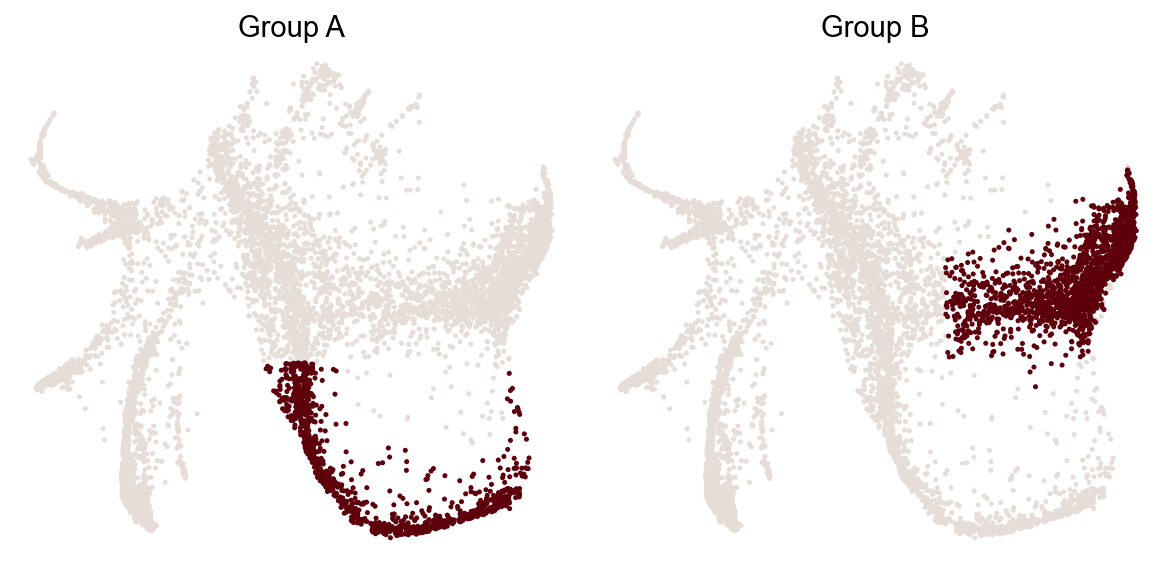

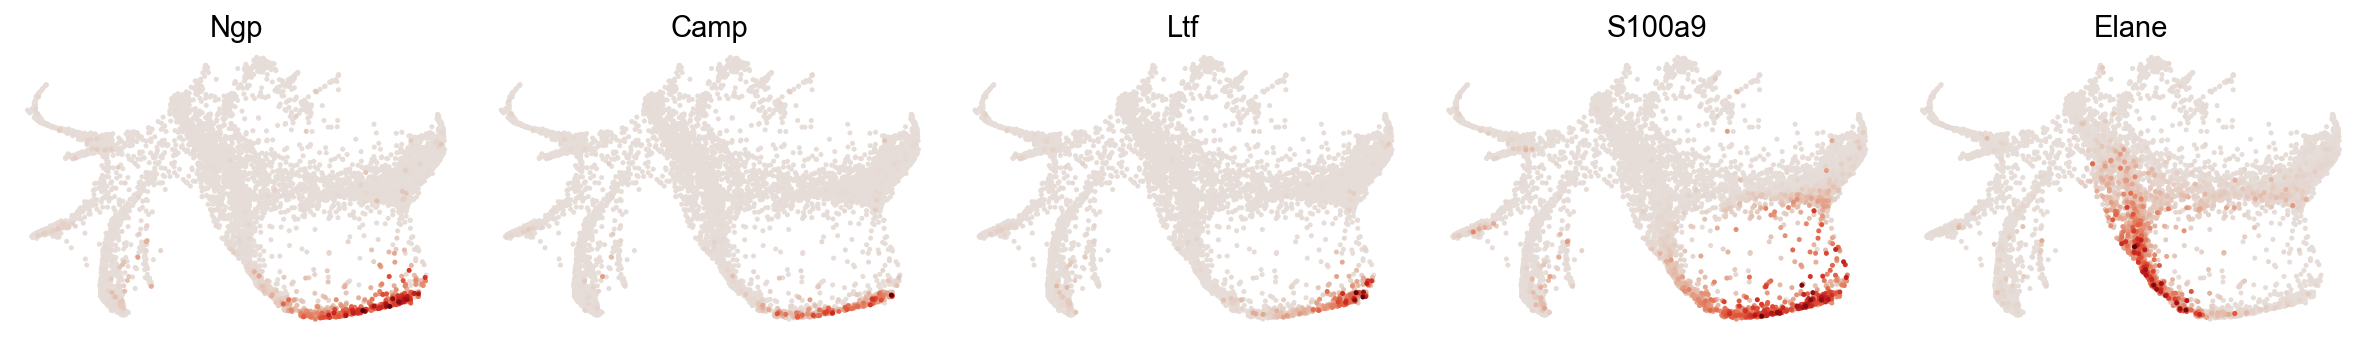

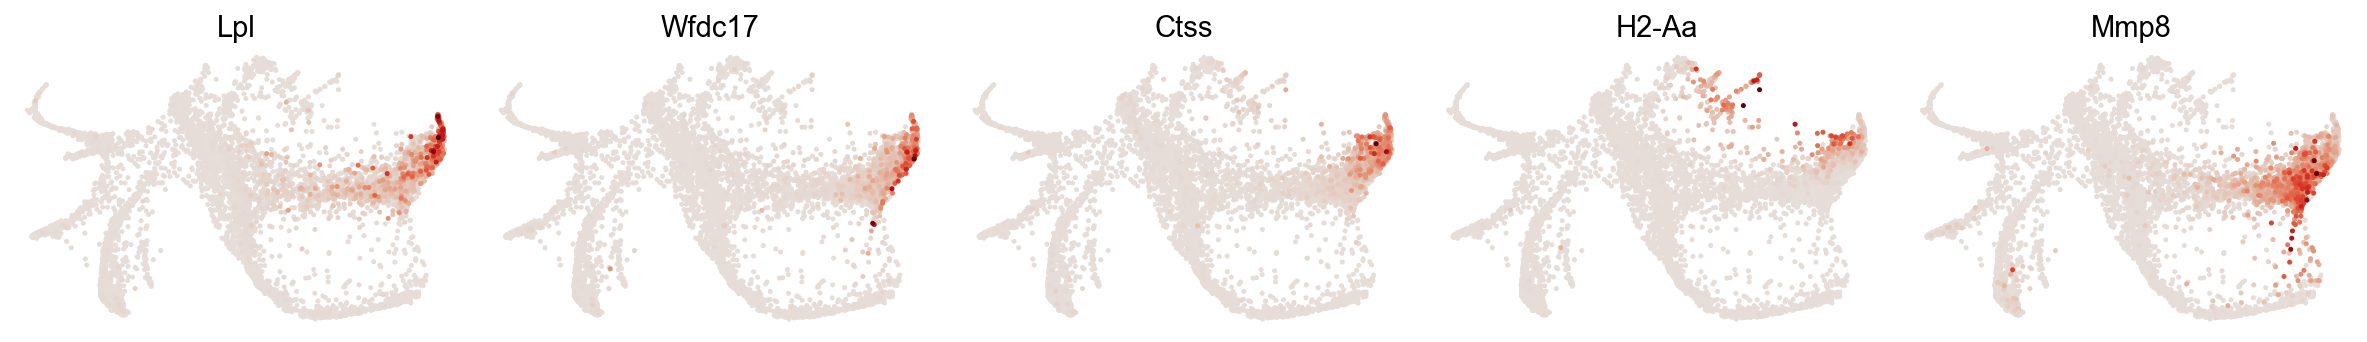

In [36]:
import numpy as np
state_info=np.array(adata.obs['state_info'])
adata.obs['cell_group_A']=state_info=='Neutrophil'
adata.obs['cell_group_B']=state_info=='Monocyte'
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=5)

### Gene trend along the dynamic trajectory

Any one of the 3 dynamic trajectory inference methods will save the trajectory at
`adata.uns['dynamic_trajectory']`. We can calculate the pseudotime along this trajectory
and plot the gene expression along this pseudo time. This method requires that `adata.uns['dynamic_trajectory']` exists, and the selected fate is in the pre-computed list.

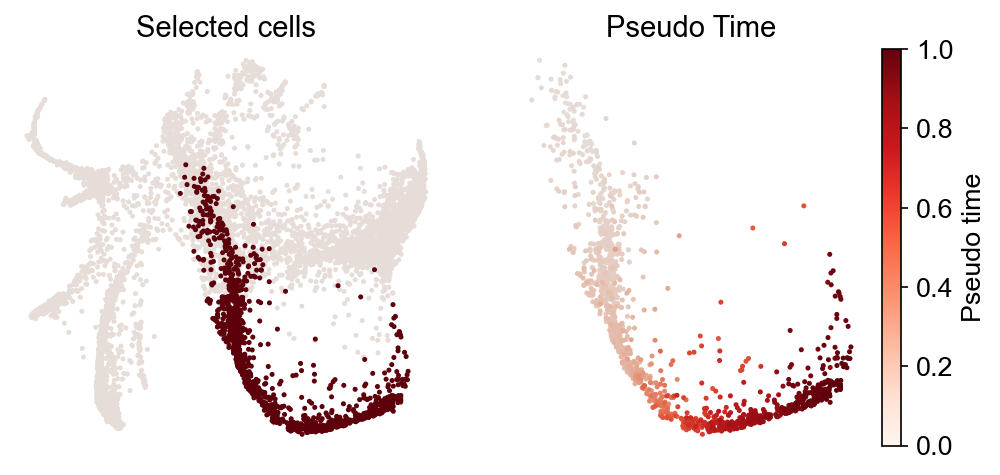

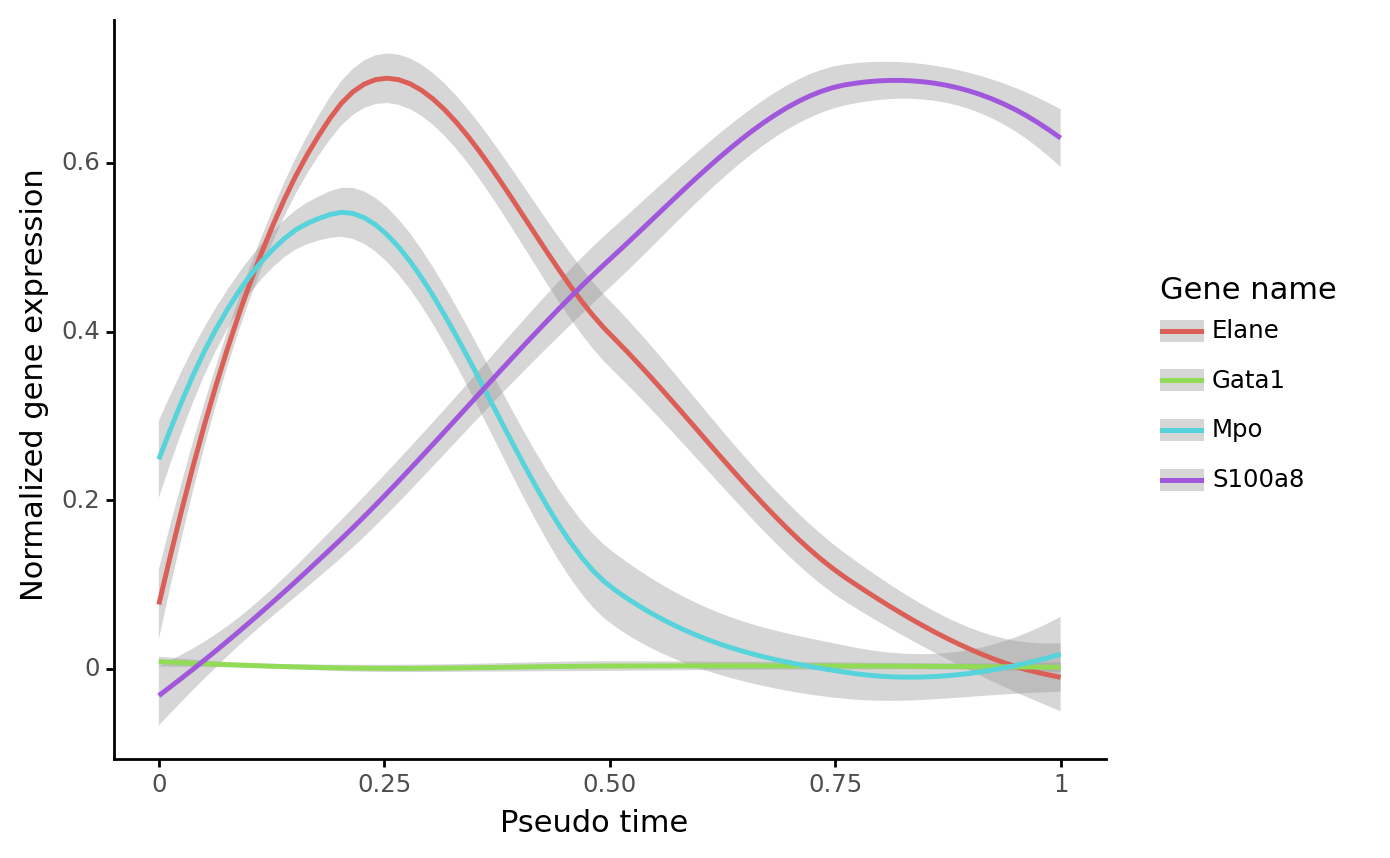

In [37]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      map_backwards=True, invert_PseudoTime=False, include_target_states=True, compute_new=True, 
      gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False)

The method outputs a new adata object with the selected cell states. This can be used to run your favoriate pseudotime analysis methods.

Trying to set attribute `.uns` of view, copying.


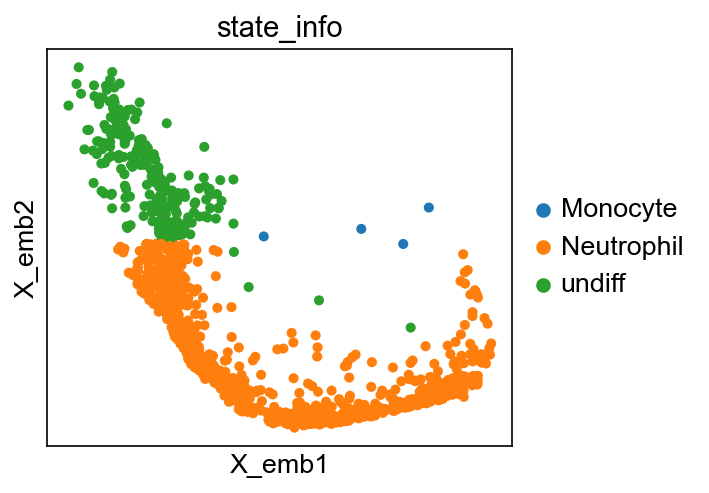

In [38]:
cs.pl.embedding(adata_selected,color='state_info')

### Fate coupling of the transition map

The inferred transition map can be used to estimate differentiation coupling between different fate clusters. 

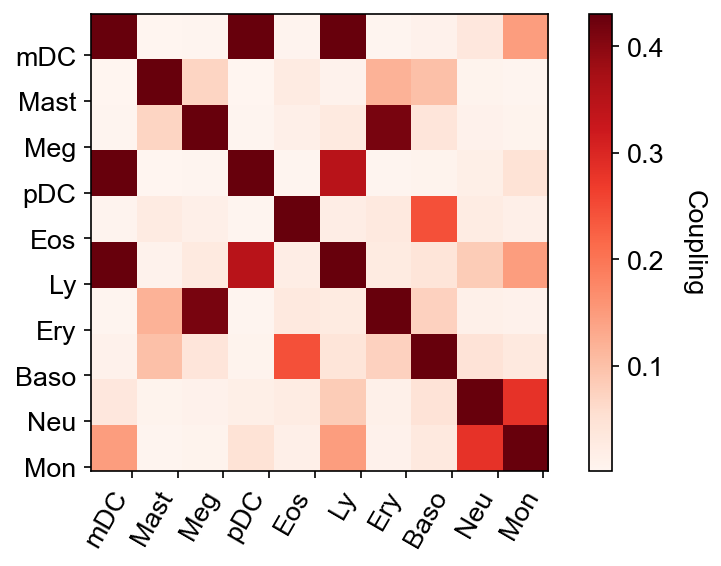

In [39]:
fate_array=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
cs.pl.fate_coupling_from_Tmap(adata,selected_fates=fate_array,used_map_name='transition_map',
                        rename_selected_fates=celltype_names)


## Miscellaneous

### Transition map from state information and the last clonal time point

After initializing the map by either *OT* method or *HighVar* method, We jointly infer the likely clonal ancestors and the transition map between cell states across given time points. You need to choose the initialization method and set the corresponding parameters.

* `OT`: optional transport based method. It tends to be more accurate than `HighVar`, but not reliable under batch differences between time points. Key parameters: 
        
    * `OT_epsilon` for the entropic regularization 
    
    * `OT_cost`: {'GED', 'SPD'}, method for computing the cost function. 'GED' uses simple gene expression distances; it is faster. 'SPD' uses the shortest path distances; it is slower but more accurate. 

* `HighVar`: a method that converts highly variable genes into pseudo clones and run coherent sparsity optimization to generate an initialized map. Although it is not as accurate as `OT`, it is robust to batch effect across time points and is used to analyze the lung dataset.  
    
    * `HighVar_gene_pctl`: percentile threshold to select highly variable genes. Range: [0,100]. A higher value selects more variable genes. 

Let us try the OT method that uses gene expression distances. It takes around 1 min to run.

In [40]:
initial_time_points=['4'] #['2','4']
clonal_time_point='6'
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points,clonal_time_point,Clone_update_iter_N=1,
        initialize_method='OT',OT_cost='GED',smooth_array=[20,15,10],noise_threshold=0.2,use_full_Smatrix=True)

-------------------------------New Start--------------------------------------------------
Current time point: 4
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Finishing computing gene expression distance, used time 5.382260084152222
Compute new custon OT matrix
OT solver: duality_gap
Finishing computing optial transport map, used time 35.946727991104126
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (7152, 500)
--> After excluding zero-sized clones at t2: (7152, 500)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal states: current clone id 200
--> Inferring early clonal states: current 

Now, check the result of the initialized map `OT_transition_map`. 

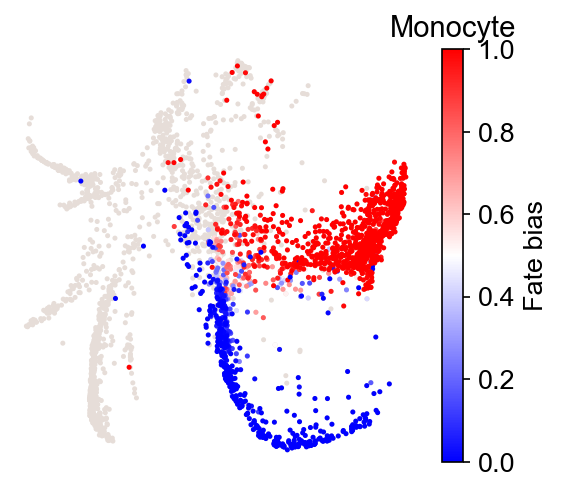

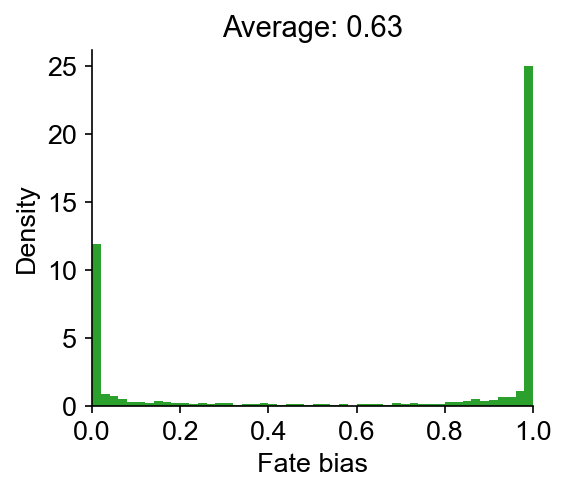

In [41]:
cs.pl.binary_fate_bias(adata,selected_fates=['Monocyte','Neutrophil'],
    used_map_name='OT_transition_map',selected_time_points=['4'],plot_target_state=False,
                                map_backwards=True,sum_fate_prob_thresh=0.1)

After joint optimization, the final result of the transition map is much better:

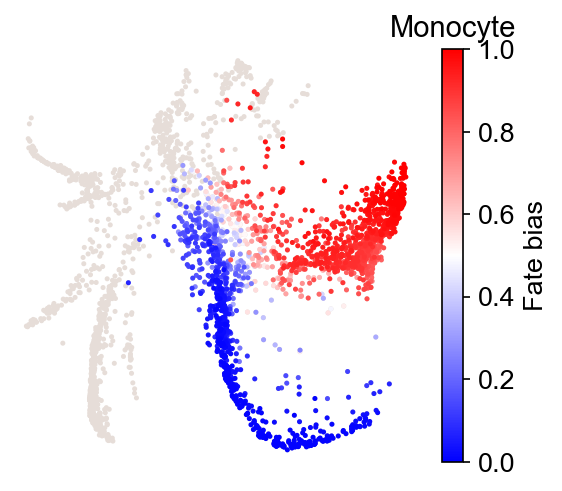

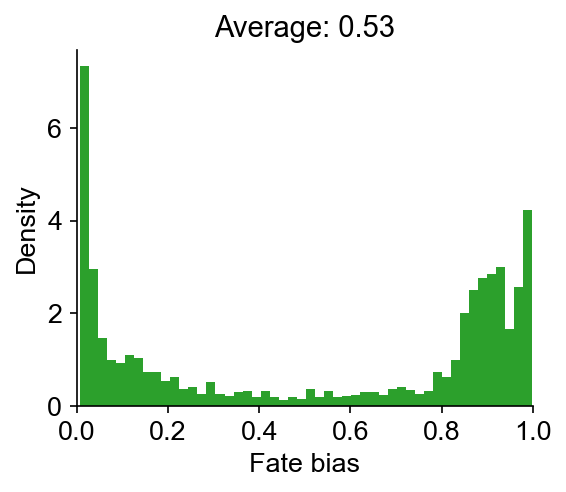

In [42]:
cs.pl.binary_fate_bias(adata,selected_fates=['Monocyte','Neutrophil'],
    used_map_name='transition_map',selected_time_points=['4'],plot_target_state=False,
                                map_backwards=True,sum_fate_prob_thresh=0.1)

### Transition map from state information alone

This is the same as `cs.tmap.infer_Tmap_from_one_time_clones`, except that we only compute the initialized map. Let us try the `HighVar` method:

-------------------------------New Start--------------------------------------------------
Current time point: 4
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use highly variable genes to construct pseudo-clones, and apply CoSpar to generate initialized map!
HighVar-v0: avoid cells that have been selected
----------------
Step a: find the commonly shared highly variable genes


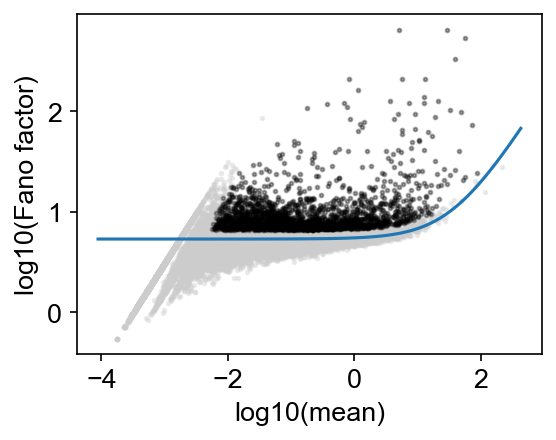

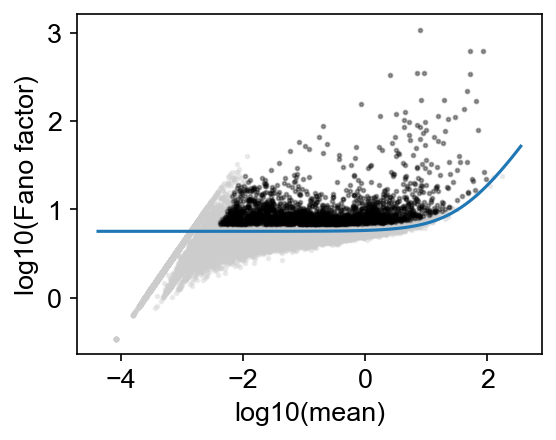

Highly varable gene number at t1 is 2136, Highly varable gene number at t2 is 2245
Common gene set is 978
----------------
Step b: convert the shared highly variable genes into clonal info
No cells left for assignment, total used genes=872
----------------
Step c: compute the transition map based on clonal info from highly variable genes
---------Compute the transition map-----------
Compute similarity matrix: load existing data
--> Time elapsed:  0.10345220565795898
--> Time elapsed:  0.12306094169616699
--> Time elapsed:  0.0782938003540039
--> Time elapsed:  0.12520718574523926
Compute similarity matrix: load existing data
--> Time elapsed:  0.06851410865783691
--> Time elapsed:  0.09643101692199707
--> Time elapsed:  0.06673789024353027
--> Time elapsed:  0.10132670402526855
Compute similarity matrix: load existing data
--> Time elapsed:  0.05354499816894531
--> Time elapsed:  0.07813096046447754
--> Time elapsed:  0.06833076477050781
--> Time elapsed:  0.07883810997009277
Current 

In [43]:
initial_time_points=['4'] #['2','4']
target_time_point='6'
adata=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points,target_time_point,
        method='HighVar',HighVar_gene_pctl=85,smooth_array=[20,15,10],noise_threshold=0.2,use_full_Smatrix=True)

You can see that this method is not as accurate for this dataset. 

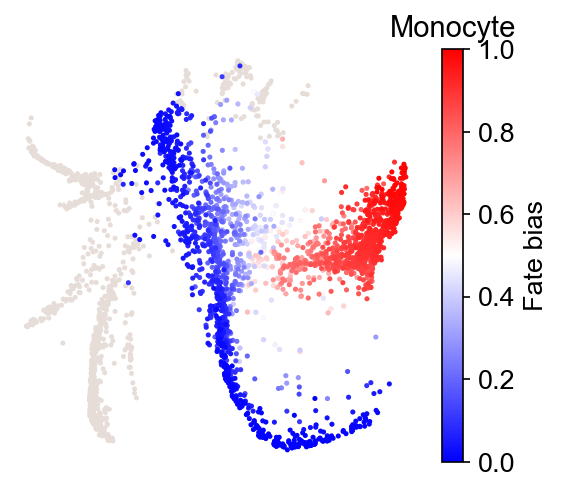

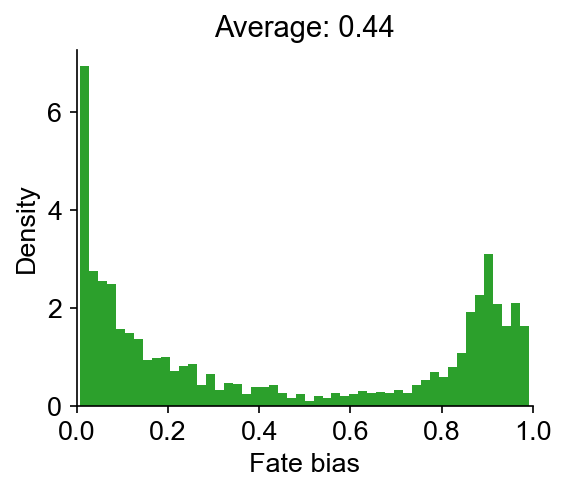

In [44]:
cs.pl.binary_fate_bias(adata,selected_fates=['Monocyte','Neutrophil'],
    used_map_name='HighVar_transition_map',selected_time_points=['4'],plot_target_state=False,
                                map_backwards=True,sum_fate_prob_thresh=0.2)

### Gene expression

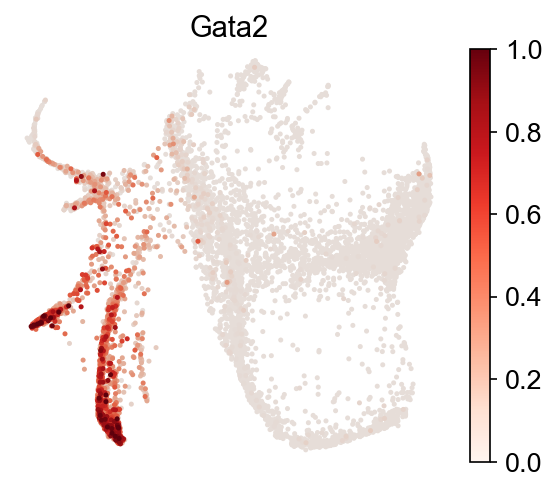

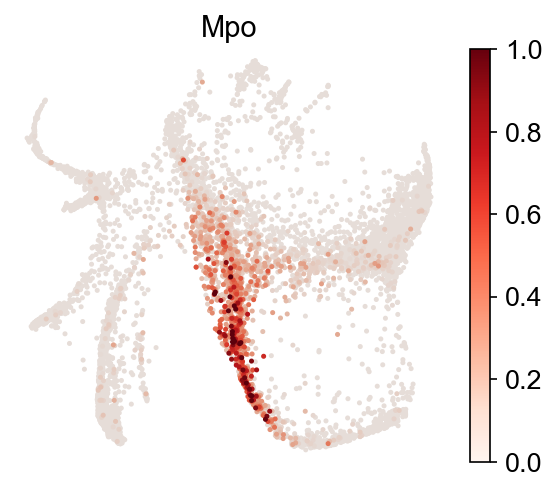

In [45]:
cs.pl.gene_expression_on_manifold(adata,selected_genes=['Gata2','Mpo'],color_bar=True,savefig=False)

### Refine state annotation by marker genes

The goal here is to refine `adata.obs['state_info']`. In this method, a state is selected if it expresses all genes in the list of 
marker_genes, and the expression is above the relative threshold `express_threshold`. 
You can also specify which time point you want to focus on. In addition, we also 
include cell states neighboring to these valid states to smooth 
the selection (controlled by `add_neighbor_N`). First, explore parameters to find satisfactory annotation.

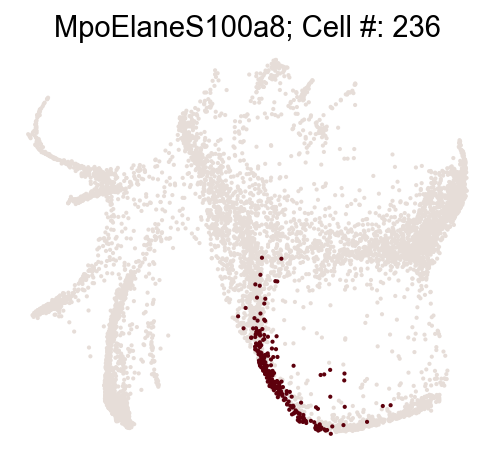

In [46]:
confirm_change=False
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata,marker_genes,express_threshold=0.1,
    selected_time_points=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

Now, confirm changes to `adata.obs['state_info']`.

Change state annotation at adata.obs['state_info']


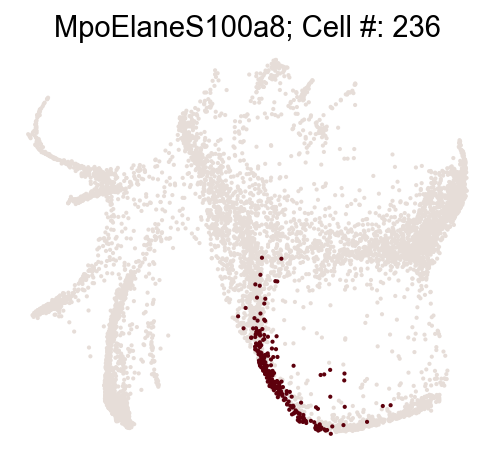

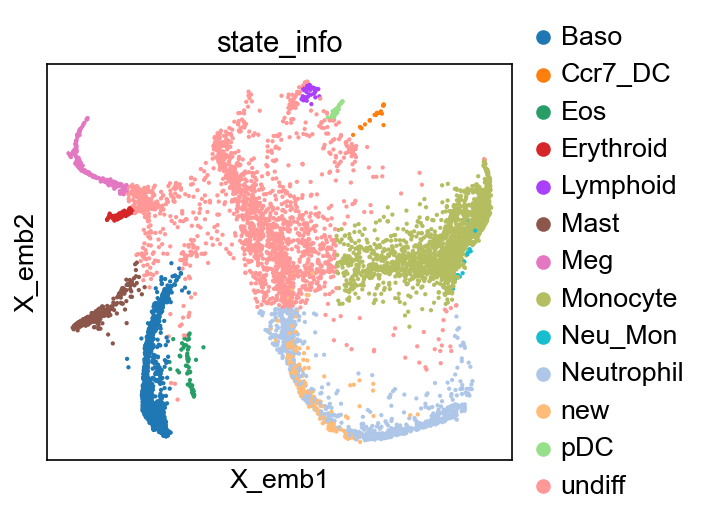

In [47]:
confirm_change=True
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata,marker_genes,express_threshold=0.1,
    selected_time_points=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

### Refine state annotation by clustering states at given time points

First, explore the parameters.

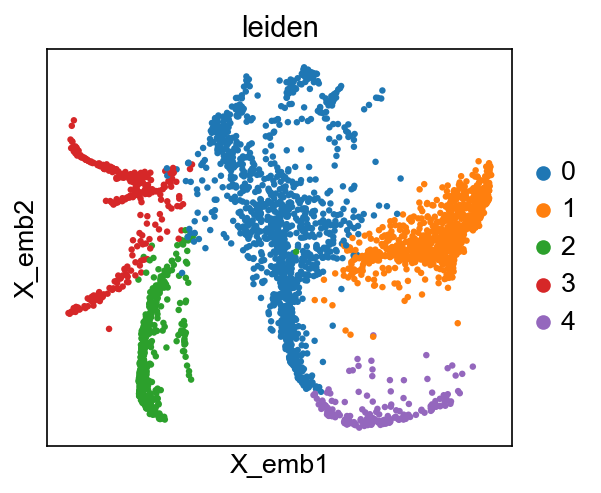

In [48]:
confirm_change=False
cs.pp.refine_state_info_by_leiden_clustering(adata,selected_time_points=['4'],n_neighbors=20,
            resolution=0.1,confirm_change=confirm_change)

Once you are happy with the result, confirm the change to `adata.obs['state_info']`.

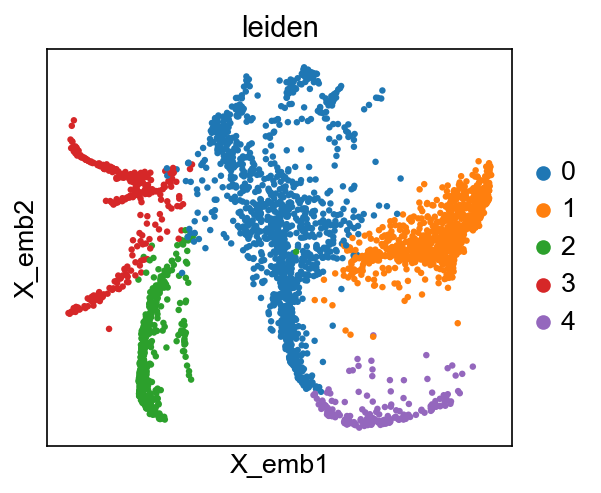

Change state annotation at adata.obs['state_info']


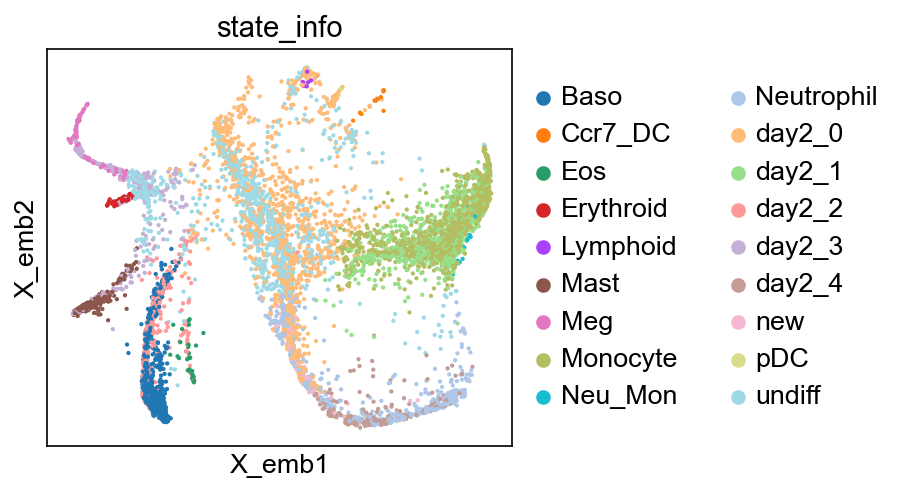

In [49]:
confirm_change=True
cs.pp.refine_state_info_by_leiden_clustering(adata,selected_time_points=['4'],n_neighbors=20,
                    resolution=0.1,confirm_change=confirm_change,cluster_name_prefix='day2_')

### Differential gene expression between two clusters

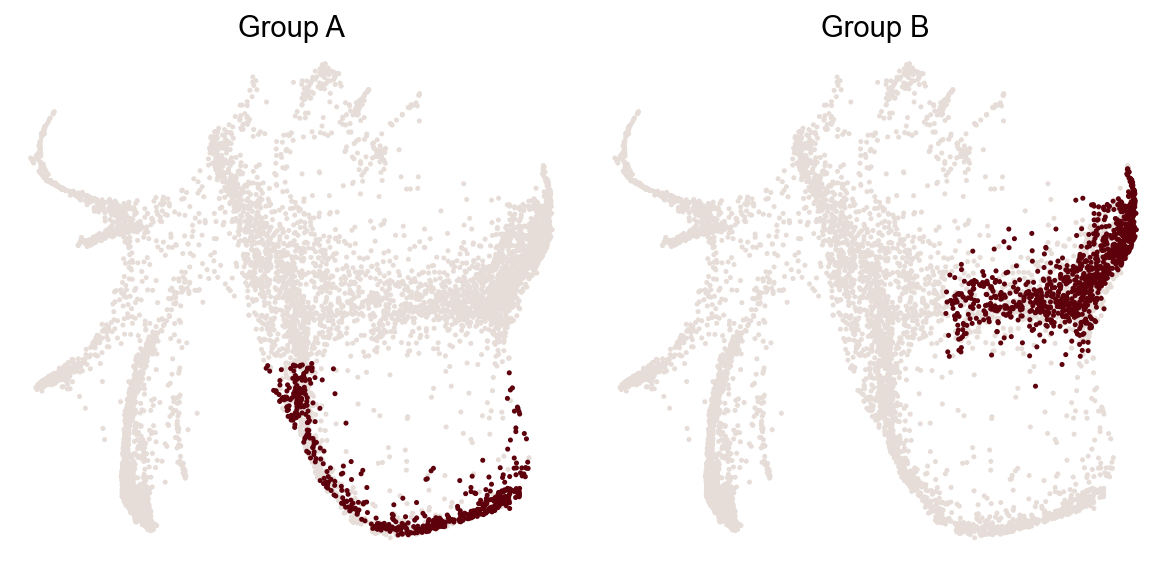

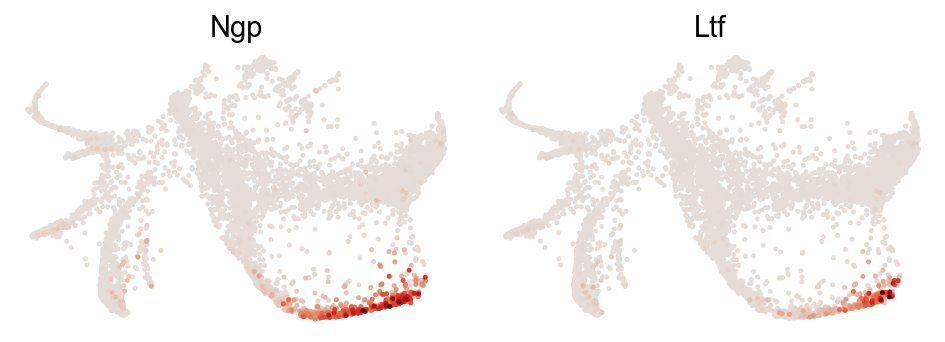

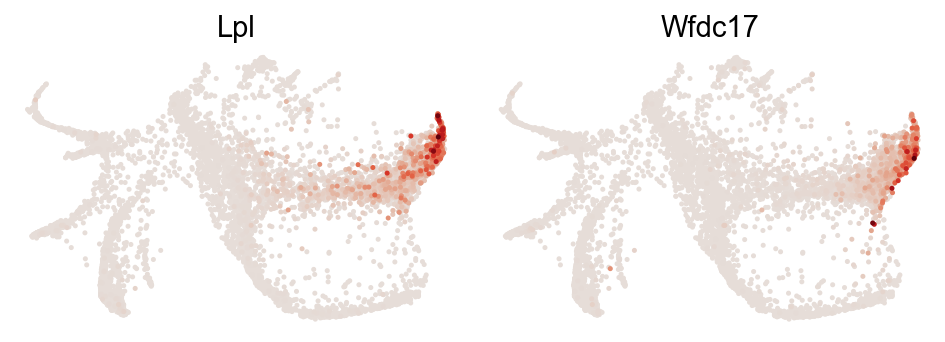

In [50]:
diff_gene_A,diff_gene_B=cs.pl.differential_genes_for_given_fates(adata,selected_fates=['Neutrophil','Monocyte'],
                                    gene_N=100,plot_gene_N=2)